# Thuật toán 3: Cây quyết định (Decision Tree)

**Mục tiêu:** Xây dựng mô hình dựa trên quy tắc (rule-based) để dự đoán bệnh tim và so sánh hiệu suất với các mô hình khác.

**Logic thuật toán:** Decision Tree hoạt động bằng cách liên tục chia dữ liệu thành các nhóm nhỏ hơn dựa trên các phép toán điều kiện về đặc trưng (ví dụ: `Age < 50?`). Nó tìm ra câu hỏi tốt nhất (giúp phân tách `target=0` và `target=1` rõ nhất) tại mỗi bước. Mô hình này rất mạnh mẽ nhưng có một rủi ro lớn: **overfitting** (học quá khớp), nghĩa là nó học thuộc lòng tập train nhưng dự đoán kém trên tập test.

**Các bước thực hiện:**
1.  **Giai đoạn 1: Tải và Tiền xử lý Dữ liệu:** Tái sử dụng quy trình (One-Hot Encoding) nhưng **loại bỏ `StandardScaler`** vì Decision Tree không yêu cầu.
2.  **Giai đoạn 2: Xây dựng Mô hình (Cơ bản):** Huấn luyện mô hình với các tham số mặc định để thấy rõ hiện tượng overfitting.
3.  **Giai đoạn 3: Đánh giá Mô hình (Cơ bản):** Đánh giá hiệu suất cơ bản.
4.  **Giai đoạn 4: Tinh chỉnh Hyperparameter (Phần chính):** Thực hiện "Cắt tỉa" (Pruning) bằng `GridSearchCV` để tìm các tham số (`max_depth`, `min_samples_leaf`) tối ưu, giúp chống overfitting.
5.  **Giai đoạn 5: Kết luận & Trực quan hóa:** Đánh giá mô hình đã được tinh chỉnh và trực quan hóa các quy tắc mà mô hình đã học.

## Giai đoạn 1: Tải và Tiền xử lý Dữ liệu

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Tải dữ liệu
data = pd.read_csv('heart.csv')

# Xóa các hàng trùng lặp
print(f"Số hàng ban đầu: {len(data)}")
data = data.drop_duplicates()
print(f"Số hàng sau khi xóa trùng lặp: {len(data)}")

# Tách X(features) và y(target)
X = data.drop('HeartDisease', axis=1)
Y = data["HeartDisease"]

# 1. Biến Categorical: One-hot Encoding
categorical_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 2. Biến Numerical: Không cần scaling:
# Decision Tree không dựa trên khoảng cách nên không cần StandardScaler.
# Bỏ qua bước này giúp chúng ta diễn giải cây dễ dàng hơn (ví dụ: 'Age > 50' thay vì 'Age > 0.5')
print("Đã bỏ qua StandardScaler một cách có chủ đích.")

print(f"Tập huấn luyện: {X_train.shape}\nTập kiểm tra: {X_test.shape}")

Số hàng ban đầu: 918
Số hàng sau khi xóa trùng lặp: 918
Đã bỏ qua StandardScaler một cách có chủ đích.
Tập huấn luyện: (734, 15)
Tập kiểm tra: (184, 15)


## Giai đoạn 2: Xây dựng Mô hình cơ bản

In [22]:
# Khởi tạo mô hình với các tham số mặc định
model_dt_default = DecisionTreeClassifier(
    random_state=42,
    max_depth=None, 
    min_samples_leaf=1
)

# Huấn luyện mô hình
model_dt_default.fit(X_train, Y_train)

print("Mô hình Decision Tree (mặc định) đã được huấn luyện.")

Mô hình Decision Tree (mặc định) đã được huấn luyện.


## Giai đoạn 3: Đánh giá Mô hình cơ bản

So sánh điểm trên tập train và tập test có thể thấy rõ sự chênh lệch (dấu hiệu của overfitting).

--- Điểm trên Tập Huấn luyện (Train) ---
F1-Score (Train): 1.0000

--- Điểm trên Tập Kiểm thử (Test) ---
Accuracy: 0.8533
Precision: 0.8636
Recall: 0.8879
F1-Score (Test): 0.8756


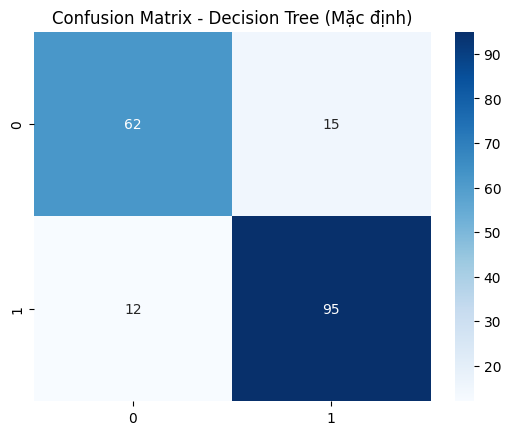

In [23]:
# Đánh giá trên tập Train
Y_pred_train = model_dt_default.predict(X_train)
f1_train = f1_score(Y_train, Y_pred_train)
print(f"--- Điểm trên Tập Huấn luyện (Train) ---")
print(f"F1-Score (Train): {f1_train:.4f}")

# Đánh giá trên tập Test
Y_pred_test = model_dt_default.predict(X_test)
f1_test = f1_score(Y_test, Y_pred_test)
print(f"\n--- Điểm trên Tập Kiểm thử (Test) ---")
print(f"Accuracy: {accuracy_score(Y_test, Y_pred_test):.4f}")
print(f"Precision: {precision_score(Y_test, Y_pred_test):.4f}")
print(f"Recall: {recall_score(Y_test, Y_pred_test):.4f}")
print(f"F1-Score (Test): {f1_test:.4f}")

# Ma trận nhầm lẫn
cm = confusion_matrix(Y_test, Y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Decision Tree (Mặc định)')
plt.show()

**Nhận xét:**
Như dự đoán, F1-Score trên tập Train là 1.0 (100%), trong khi trên tập Test là 0.8756. Sự chênh lệch này là minh chứng cho **overfitting**.

## Giai đoạn 4: Tinh chỉnh Hyperparameter (Cắt tỉa - Pruning)

**Logic:**
Để chống overfitting, chúng ta phải cắt tỉa (prune) cây. Chúng ta sẽ dùng `GridSearchCV` để tìm ra các tham số giới hạn độ phức tạp của cây một cách tốt nhất.

**Các siêu tham số (Hyperparameters) chính:**
* `max_depth`: Độ sâu tối đa của cây. Giảm số này giúp giảm overfitting.
* `min_samples_split`: Số lượng mẫu tối thiểu cần có trong một nút (node) để được phép chia (split) tiếp. Tăng số này giúp giảm overfitting.
* `min_samples_leaf`: Số lượng mẫu tối thiểu phải có ở mỗi nút lá (leaf). Tăng số này giúp giảm overfitting.
* `criterion`: Tiêu chí để đo lường chất lượng của một phép chia (`gini` hoặc `entropy`).

In [24]:
# 2. Tinh chỉnh toàn diện (GridSearchCV)
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4, 5, 6, 7, 8, 10],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [5, 10, 15]
}

# Khởi tạo GridSearchCV (tối ưu theo Recall)
grid_search_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid_dt,
    scoring='recall',
    cv=5,
    n_jobs=-1
)

# Chạy GridSearch trên tập huấn luyện
grid_search_dt.fit(X_train, Y_train)

# In ra các tham số tốt nhất
print(f"Best Hyperparameters: {grid_search_dt.best_params_}")
print (f"Best Recall from GridSearchCV: {grid_search_dt.best_score_:.4f}")

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 20}
Best Recall from GridSearchCV: 0.8853


## Giai đoạn 5: Đánh giá Mô hình Tinh chỉnh & Trực quan hóa

Bây giờ chúng ta sẽ đánh giá mô hình tốt nhất trên tập Test. Chúng ta kỳ vọng điểm F1-Score trên tập Test sẽ **cao hơn** mô hình mặc định (vì mô hình tổng quát hóa tốt hơn) và điểm trên tập Train sẽ **thấp hơn** 100%.

--- Điểm trên Tập Huấn luyện sau khi Tuning ---
F1-Score (Train): 0.8826

--- Kết quả đánh giá Decision Tree sau khi Tuning ---
Accuracy: 0.8696
Precision: 0.8879
Recall: 0.8879
F1-Score: 0.8879


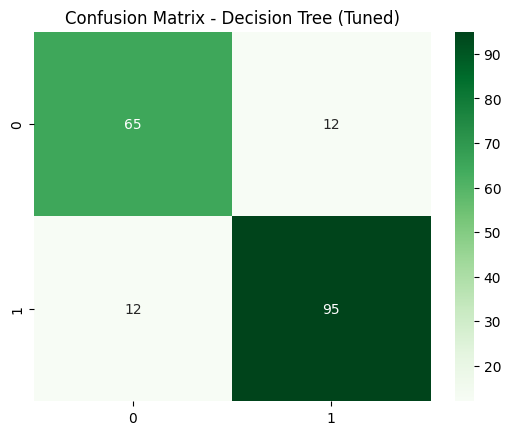

In [25]:
# Lấy mô hình tốt nhất
best_model_dt = grid_search_dt.best_estimator_

# Đánh giá trên tập Train
Y_pred_train_best = best_model_dt.predict(X_train)
f1_train_best = f1_score(Y_train, Y_pred_train_best)
print(f"--- Điểm trên Tập Huấn luyện sau khi Tuning ---")
print(f"F1-Score (Train): {f1_train_best:.4f}")

# Đánh giá trên tập Test
Y_pred_best = best_model_dt.predict(X_test)

print("\n--- Kết quả đánh giá Decision Tree sau khi Tuning ---")
print(f"Accuracy: {accuracy_score(Y_test, Y_pred_best):.4f}")
print(f"Precision: {precision_score(Y_test, Y_pred_best):.4f}")
print(f"Recall: {recall_score(Y_test, Y_pred_best):.4f}")
print(f"F1-Score: {f1_score(Y_test, Y_pred_best):.4f}")

# Ma trận nhầm lẫn sau khi tuning
cm_best = confusion_matrix(Y_test, Y_pred_best)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Decision Tree (Tuned)')
plt.show()

### Trực quan hóa Cây Quyết định

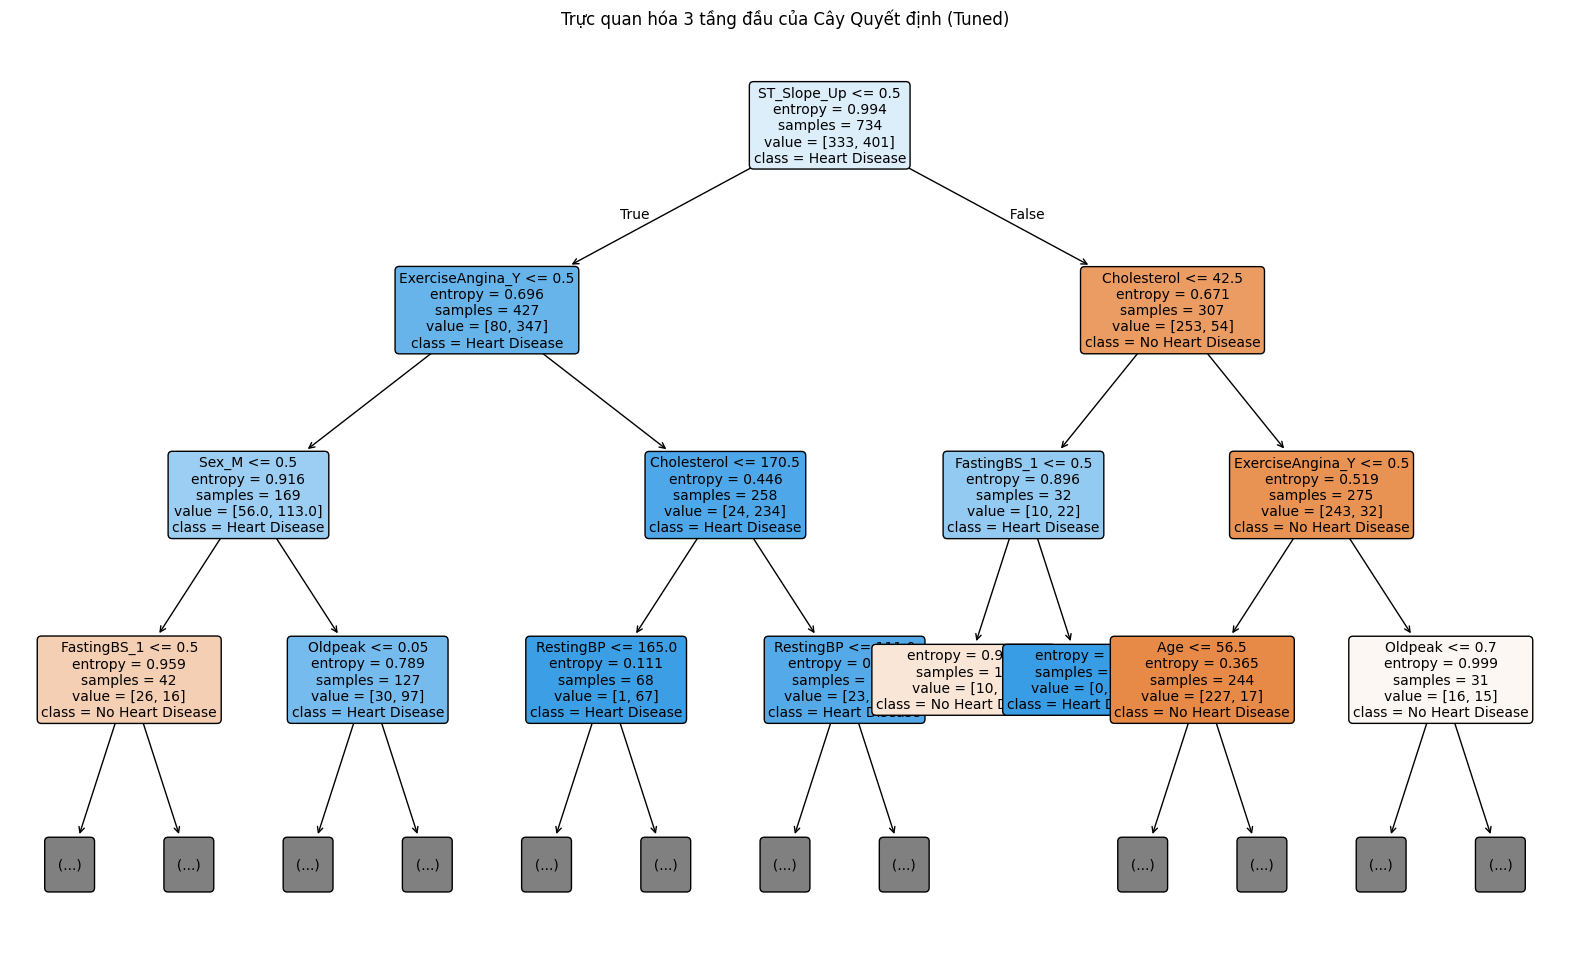

In [ ]:
plt.figure(figsize=(20, 12))
# Lấy tên các đặc trưng sau khi đã One-Hot Encoding
feature_names = X.columns.tolist()
# Tên các class
class_names = ['No Heart Disease', 'Heart Disease']

# Vẽ cây
plot_tree(
    best_model_dt, 
    feature_names=feature_names, 
    class_names=class_names, 
    filled=True, 
    rounded=True, 
    fontsize=10,
    max_depth=4
)
plt.title("Trực quan hóa 4 tầng đầu của Cây Quyết định (Tuned)")
plt.show()